In [257]:
import os
import numpy as np
import torch
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
from bb_opt.src.hsic import dimwise_mixrq_kernels, dimwise_mixrbf_kernels, total_hsic

# os.environ[""] = "PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"] = "1"
# device = torch

%matplotlib inline

# 2D Distributions

In [249]:
from scipy.spatial.distance import pdist, squareform

def distcorr(X, Y):
    """
    Compute the distance correlation function.
    From https://gist.github.com/satra/aa3d19a12b74e9ab7941.

    >>> a = [1,2,3,4,5]
    >>> b = np.array([1,2,9,4,4])
    >>> distcorr(a, b)
    0.762676242417
    """
    X = np.atleast_1d(X)
    Y = np.atleast_1d(Y)
    if np.prod(X.shape) == len(X):
        X = X[:, None]
    if np.prod(Y.shape) == len(Y):
        Y = Y[:, None]
    X = np.atleast_2d(X)
    Y = np.atleast_2d(Y)
    n = X.shape[0]
    if Y.shape[0] != X.shape[0]:
        raise ValueError('Number of samples must match')
    a = squareform(pdist(X))
    b = squareform(pdist(Y))
    A = a - a.mean(axis=0)[None, :] - a.mean(axis=1)[:, None] + a.mean()
    B = b - b.mean(axis=0)[None, :] - b.mean(axis=1)[:, None] + b.mean()
    
    dcov2_xy = (A * B).sum()/float(n * n)
    dcov2_xx = (A * A).sum()/float(n * n)
    dcov2_yy = (B * B).sum()/float(n * n)
    dcor = np.sqrt(dcov2_xy)/np.sqrt(np.sqrt(dcov2_xx) * np.sqrt(dcov2_yy))
    return dcor

In [195]:
def rotated_square(radians, max_val: int=2.7):
    min_val = -max_val
    x = min_val + (max_val - min_val) * np.random.rand(n)
    y = min_val + (max_val - min_val) * np.random.rand(n)

    r = np.sqrt(x ** 2 + y ** 2)
    theta = np.arctan2(y, x) + radians

    x = r * np.cos(theta)
    y = r * np.sin(theta)
    return x, y

def sine(max_val: int=3):
    min_val = -max_val
    x = min_val + (max_val - min_val) * np.random.rand(n)
    y = 2 * np.sin(2 * x + np.pi / 2) + np.random.normal(0, .5, size=len(x))
    return x, y

def parabola(max_val: int=3):
    x = min_val + (max_val - min_val) * np.random.rand(n)
    y = np.abs(x) ** 1.5 - 3.5 + 3 * np.random.rand(n)
    return x, y

def double_parabola(max_val: int=3):
    x = min_val + (max_val - min_val) * np.random.rand(n)
    y = np.concatenate([abs(x[:n // 2]) ** 1.5, -(abs(x[n // 2:]) ** 1.5)]) + np.random.rand(n)
    return x, y

def circle():
    r = np.ones(n) * 3 + np.random.normal(0, .35, n)
    theta = 2 * np.pi * np.random.rand(n)

    x = r * np.cos(theta)
    y = r * np.sin(theta)
    return x, y

def double_normal():
    std = 0.6
    mean = 2
    x = np.concatenate([np.random.normal(-mean, std, n // 2), np.random.normal(mean, std, n // 2)])
    y = np.concatenate([np.random.normal(-mean, std, n // 2), np.random.normal(mean, std, n // 2)])

    np.random.shuffle(y)
    return x, y

In [234]:
funcs = [
    *[lambda p=prob: [x, p * x + (1 - p) * np.random.normal(0, 1, len(x))] for prob in [1, 0.65, 0.35, 0]],
    *[lambda p=prob: [x, p * -x + (1 - p) * np.random.normal(0, 1, len(x))] for prob in [0.35, 0.65, 1]],
    *[lambda m=slope: [x, m * x] for slope in [1, 0.6, 0.3, 0, -0.3, -0.6, -1]],
    sine,
    lambda: rotated_square(np.pi / 8),
    lambda: rotated_square(np.pi / 4),
    parabola,
    double_parabola,
    circle,
    double_normal
]

/cluster/nhunt/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:3003: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
/cluster/nhunt/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in double_scalars


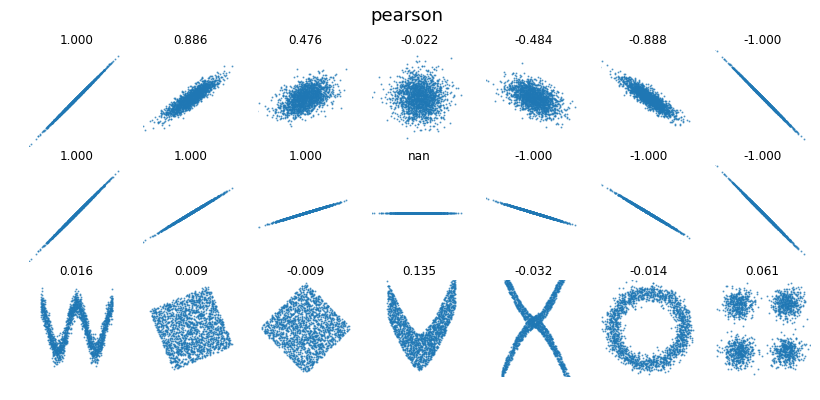

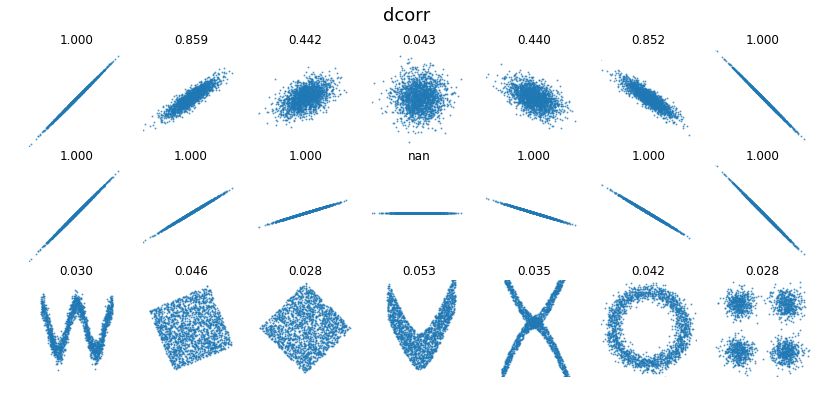

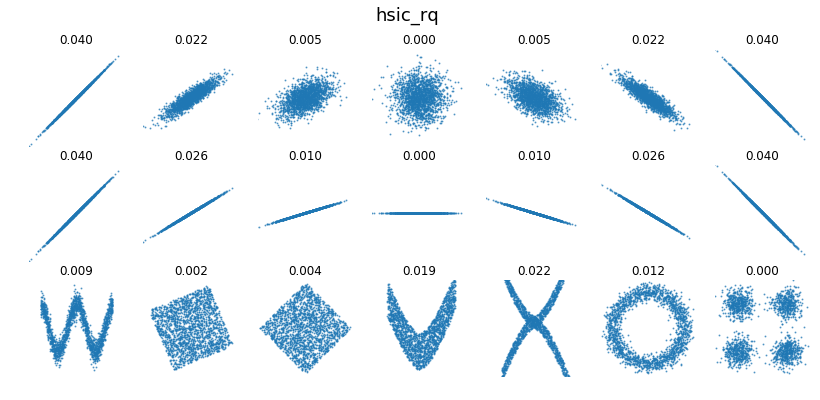

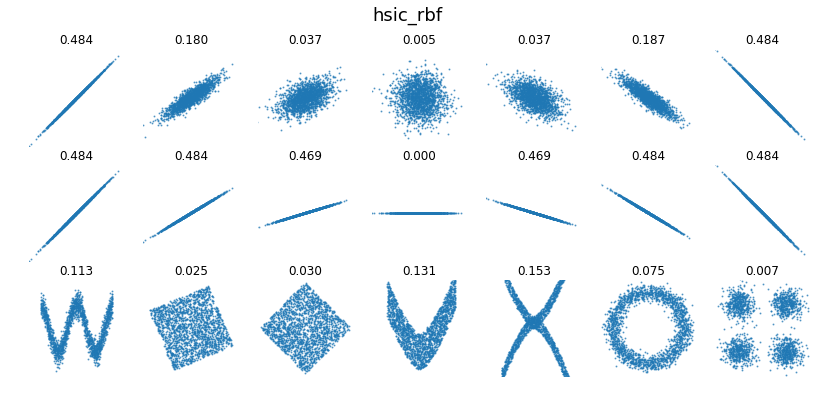

In [271]:
n = 2000
x = np.random.normal(0, 1, n)
plot_funcs(funcs, metric="pearson")
plot_funcs(funcs, metric="dcorr")
plot_funcs(funcs, metric="hsic_rq")
plot_funcs(funcs, metric="hsic_rbf")

In [260]:
def plot_funcs(funcs, metric="pearson", n_cols = 7, width = 14):
    n_rows = int(np.ceil(len(funcs) / n_cols))

    plt.figure(figsize=(width, width / n_cols * n_rows))
    plt.suptitle(metric, fontsize=18)
    for i, f in enumerate(funcs):
        x_, y = f()

        if metric == "pearson":
            metric_val = pearsonr(x_, y)[0]
        elif metric == "hsic_rq":
            metric_val = total_hsic(dimwise_mixrq_kernels(torch.tensor(np.stack((x_, y)).T))).item()
        elif metric == "hsic_rbf":
            metric_val = total_hsic(dimwise_mixrbf_kernels(torch.tensor(np.stack((x_, y)).T))).item()
        elif metric == "dcorr":
            metric_val = distcorr(x, y)
        else:
            assert False

        plt.subplot(n_rows, n_cols, i + 1)
        plt.scatter(x_, y, s=1, alpha=0.6)
        plt.xlim(-4, 4)
        plt.ylim(-4, 4)
        plt.title(f"{metric_val:.3f}")
        plt.axis('off')

# Actual Data

* Should HSIC ever go down as you're constructing a batch?
* Look at RBF errors - what is overflowing? Just do a random batch